In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex5 import *

/tmp/ipykernel_37/195640296.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/usr/local/lib/python3.11/dist-packages/learntools/deep_learning_intro/ex5.py:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if layer.__class__.__name__ is 'Dense']
/usr/local/lib/python3.11/dist-packages/learntools/deep_learning_intro/ex5.py:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if layer.__class__.__name__ is 'Dense']
/usr/local/lib/python3.11/dist-packages/learntools/deep_learning_intro/ex5.py:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if layer.__class__.__name__ is 'Dropout']
/usr/local/lib/python3.11/dist-packages/learntools/deep_learning_intro/ex5.py:106: SyntaxWarning: "is" with a lite

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

# Load and preprocess data (same as original code)
spotify = pd.read_csv('../input/dl-course-data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

# Convert preprocessed NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_valid_tensor = torch.from_numpy(X_valid).float()
y_train_tensor = torch.from_numpy(y_train.values).float().unsqueeze(1)
y_valid_tensor = torch.from_numpy(y_valid.values).float().unsqueeze(1)

input_shape = [X_train_tensor.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [5]:
import torch
import torch.nn as nn

# Assuming input_shape is a list, e.g., [18]
input_size = input_shape[0]  # Get the integer value from the list

model = SimpleMLP(input_size)

class SimpleMLP(nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # First dropout layer
        self.layer2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)  # Second dropout layer
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout1(x)  # Apply dropout after the first layer's activation
        x = self.relu(self.layer2(x))
        x = self.dropout2(x)  # Apply dropout after the second layer's activation
        x = self.output_layer(x)
        return x

model = SimpleMLP(input_size)

Epoch [1/50], Training Loss: 0.2479, Validation Loss: 0.2101
Epoch [2/50], Training Loss: 0.2150, Validation Loss: 0.2018
Epoch [3/50], Training Loss: 0.2107, Validation Loss: 0.2037
Epoch [4/50], Training Loss: 0.2081, Validation Loss: 0.1976
Epoch [5/50], Training Loss: 0.2051, Validation Loss: 0.1994
Epoch [6/50], Training Loss: 0.2040, Validation Loss: 0.1984
Epoch [7/50], Training Loss: 0.2027, Validation Loss: 0.2014
Epoch [8/50], Training Loss: 0.2015, Validation Loss: 0.1977
Epoch [9/50], Training Loss: 0.2015, Validation Loss: 0.1958
Epoch [10/50], Training Loss: 0.2006, Validation Loss: 0.1968
Epoch [11/50], Training Loss: 0.1992, Validation Loss: 0.1960
Epoch [12/50], Training Loss: 0.1990, Validation Loss: 0.1942
Epoch [13/50], Training Loss: 0.1981, Validation Loss: 0.1951
Epoch [14/50], Training Loss: 0.1973, Validation Loss: 0.1942
Epoch [15/50], Training Loss: 0.1969, Validation Loss: 0.1931
Epoch [16/50], Training Loss: 0.1968, Validation Loss: 0.1947
Epoch [17/50], Tr

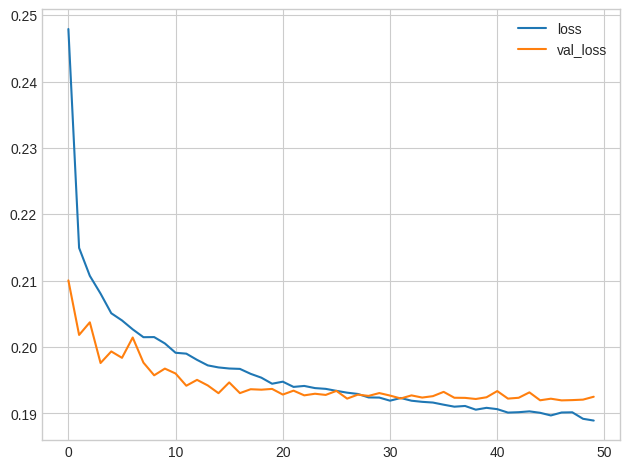

Minimum Validation Loss: 0.1920


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_valid, and y_valid are already NumPy arrays

# 1. Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train.values).float().unsqueeze(1)
X_valid_tensor = torch.from_numpy(X_valid).float()
y_valid_tensor = torch.from_numpy(y_valid.values).float().unsqueeze(1)

# 2. Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=512)

# 3. Define the PyTorch Model (assuming SimpleMLP is defined with dropout)
# from your previous code snippets
input_size = X_train.shape[1]
model = SimpleMLP(input_size)

# 4. Define Loss Function and Optimizer
criterion = nn.L1Loss()  # 'mae' in Keras is L1Loss in PyTorch
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. The PyTorch Training and Validation Loop
history = {'loss': [], 'val_loss': []}
num_epochs = 50

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    history['loss'].append(avg_train_loss)

    # Validation
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    avg_valid_loss = valid_loss / len(valid_loader.dataset)
    history['val_loss'].append(avg_valid_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_valid_loss:.4f}')

# 6. Plotting the history
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

# 7. Print minimum validation loss
min_val_loss = history_df['val_loss'].min()
print(f"Minimum Validation Loss: {min_val_loss:.4f}")

# Evaluate Dropout Layer

In [7]:
concrete = pd.read_csv('../input/dl-course-data/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1).values.astype(np.float32)
X_valid = df_valid.drop('CompressiveStrength', axis=1).values.astype(np.float32)
y_train = df_train['CompressiveStrength'].values.astype(np.float32)
y_valid = df_valid['CompressiveStrength'].values.astype(np.float32)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
X_valid_tensor = torch.from_numpy(X_valid)
y_train_tensor = torch.from_numpy(y_train).unsqueeze(1)
y_valid_tensor = torch.from_numpy(y_valid).unsqueeze(1)

input_shape = [X_train.shape[1]]

Epoch [10/100], Training Loss: nan, Validation Loss: nan
Epoch [20/100], Training Loss: nan, Validation Loss: nan
Epoch [30/100], Training Loss: nan, Validation Loss: nan
Epoch [40/100], Training Loss: nan, Validation Loss: nan
Epoch [50/100], Training Loss: nan, Validation Loss: nan
Epoch [60/100], Training Loss: nan, Validation Loss: nan
Epoch [70/100], Training Loss: nan, Validation Loss: nan
Epoch [80/100], Training Loss: nan, Validation Loss: nan
Epoch [90/100], Training Loss: nan, Validation Loss: nan
Epoch [100/100], Training Loss: nan, Validation Loss: nan


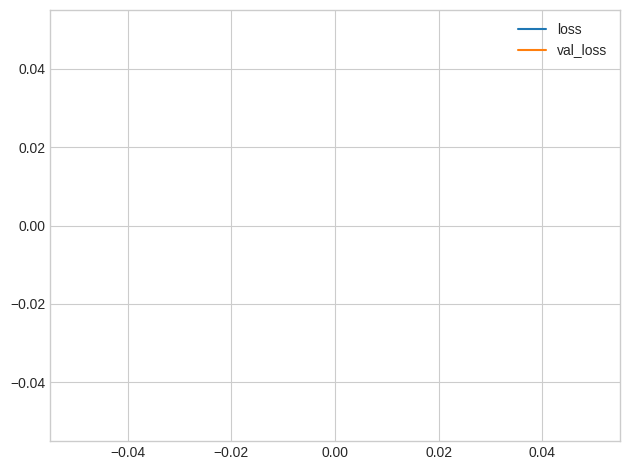

Minimum Validation Loss: nan


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_valid, and y_valid are already NumPy arrays
# and SimpleMLP class is defined from a previous response.

# 1. Define the PyTorch Model
class SimpleMLP(nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 512)
        self.output_layer = nn.Linear(512, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.output_layer(x)
        return x

input_size = X_train.shape[1]
model = SimpleMLP(input_size)

# 2. Convert Data to Tensors and create DataLoaders
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_valid_tensor = torch.from_numpy(X_valid).float()
y_valid_tensor = torch.from_numpy(y_valid).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=64)

# 3. Define Loss Function and Optimizer
criterion = nn.L1Loss() # 'mae' in Keras
optimizer = optim.SGD(model.parameters(), lr=0.01) # Default SGD learning rate

# 4. The PyTorch Training and Validation Loop
history = {'loss': [], 'val_loss': []}
num_epochs = 100

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    history['loss'].append(avg_train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    avg_valid_loss = valid_loss / len(valid_loader.dataset)
    history['val_loss'].append(avg_valid_loss)
    
    # Optional: print progress for epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_valid_loss:.4f}')

# 5. Plotting and Printing Results
history_df = pd.DataFrame(history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
plt.show()

print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# Add BatchNormalisation Layer

In [9]:
import torch
import torch.nn as nn

class SimpleMLP_BN(nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP_BN, self).__init__()
        
        self.input_bn = nn.BatchNorm1d(input_size) # BN for the input layer
        self.layer1 = nn.Linear(input_size, 512)
        
        self.bn1 = nn.BatchNorm1d(512) # BN after the first dense layer
        self.layer2 = nn.Linear(512, 512)
        
        self.bn2 = nn.BatchNorm1d(512) # BN after the second dense layer
        self.layer3 = nn.Linear(512, 512)
        
        self.bn3 = nn.BatchNorm1d(512) # BN after the third dense layer
        self.output_layer = nn.Linear(512, 1)

    def forward(self, x):
        x = self.input_bn(x)
        x = self.layer1(x)
        x = nn.functional.relu(x)
        
        x = self.bn1(x)
        x = self.layer2(x)
        x = nn.functional.relu(x)

        x = self.bn2(x)
        x = self.layer3(x)
        x = nn.functional.relu(x)

        x = self.bn3(x)
        x = self.output_layer(x)
        return x

# Assuming 'input_size' is defined
model = SimpleMLP_BN(input_size)